#### Classification | MVP

# Predicting Heart Disease<a id='top'></a> 

## **Analysis Goal**  
The client, [Kaiser Permanente](https://healthy.kaiserpermanente.org/front-door), a [health maintenance organization (HMO)](https://www.investopedia.com/terms/h/hmo.asp) and integrated managed care consortium, wants to lower the cost of running the organization and requested a model to determine which patients are at high risk of heart disease before they have a heart attack. 

Heart disease is the [leading cause](https://www.cdc.gov/heartdisease/facts.htm) of death in the U.S. for men and women. The risk factors that increase a person's risk are: diabetes, overweight and obesity, unhealthy diet, physical inactivity, and excessive alcohol use. 

**RQ:** Could a model predict the probability of a patient having heart disease based on demographics, health behaviors, health conditions, and health measures?

## **Process**
**Data source:** 
[Personal Key Indicators of Heart Disease](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease) excerpted from CDC's health survey, the [BRFSS](https://www.cdc.gov/brfss/index.html). The [dataset](#2) (n= 319,795) has 17 features which are survey responses; a mix of numeric, binary (yes/no, male, female), categorical (White, Black, Asian, American Indian/Alaskan Native, Other, Hispanic) and  Likert scale (poor, fair, good, very good, excellent).<br/> 

**Error metric:** Recall to have high confidence that the model does not miss any patients at risk for heart disease.<br/> 

**Models:** 
* Baseline model, fit a [logistic regression using mapped variables](### 3c. Baseline: Logistic regression using mapped variables<a id='3c'></a>):
    * recall score of map_df on X_test_scaled and y_test: 0.5327
    * recall score  of map_df on y_validate and y_pred: 0.0995
    * ROC AUC score mapped: 0.8411


* First iteration, fit a [logistic regression using dummy variables](#4c):
    * recall score of dummy_df on X_test_scaled and y_test: 0.5318
    * recall score of dummy_df on y_validate and y_pred: 0.1053
    * ROC AUC score dummy: 0.8363


## **Preliminary Visualizations**
[Figure 1. Heart Disease Probability by Age and Gender](#3a)<br/>
[Figure 2. ROC Curve: Logistic Regression + Mapped Features](#5a)<br/>
[Figure 3. ROC Curve: Logistic Regression + Dummy Variables](#5b)

## **Preliminary Conclusions**
The baseline logistic regression model using the mapped variables scored best on recall and ROC AUC, but only slightly better than the iteration model with dummy variables.<br/>

The next step for this analysis is to classify patients' risk of heart disease using decision trees and engineer features to lower the model's complexity. Proposed engineered features are demographics (age, gender, race), disease (asthma, diabetes, kidney, skin, stroke), health measures (BMI, general health, mental health, physical health, mobility), health behaviors (physical activity, sleep time, alcohol use, tobacco use). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.compose import make_column_transformer
from sklearn.ensemble import AdaBoostRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression ,LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC ,SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

from xgboost import XGBClassifier
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

[back to top](#top)

## 1 | Dataset: [Personal Key Indicators of Heart Disease](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease)<a id='1'></a>  

In [2]:
df = pd.read_csv('heart_2020_cleaned.csv')

In [3]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

[back to top](#top)

## 2 | Exploratory Data Analysis<a id='2'></a>  

In [5]:
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


In [6]:
df.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [7]:
# rename columns for readability
df.rename(columns = {'HeartDisease': 'y_heart_disease',
                     'Smoking': 'behavior_tobacco',
                     'AlcoholDrinking':'behavior_alcohol', 
                     'SleepTime': 'behavior_sleep',
                     'PhysicalActivity':'behavior_activity',
                     'AgeCategory':'demg_age', 
                     'Sex': 'demg_gender',
                     'Race': 'demg_race',
                     'Stroke': 'disease_stroke',
                     'Diabetic':'disease_diabetes',
                     'KidneyDisease': 'disease_kidney',
                     'Asthma': 'disease_asthma',
                     'SkinCancer': 'disease_skin',                     
                     'GenHealth': 'health_general',
                     'BMI': 'health_bmi',
                     'MentalHealth':'health_mental',
                     'PhysicalHealth': 'health_physical', 
                     'DiffWalking': 'health_mobility'}, inplace = True)

df = df.sort_index(axis=1)


In [8]:
# list unique values by column to determine which ones need to be transformed
for col in df:
    print(col, df[col].unique())

behavior_activity ['Yes' 'No']
behavior_alcohol ['No' 'Yes']
behavior_sleep [ 5.  7.  8.  6. 12.  4.  9. 10. 15.  3.  2.  1. 16. 18. 14. 20. 11. 13.
 17. 24. 19. 21. 22. 23.]
behavior_tobacco ['Yes' 'No']
demg_age ['55-59' '80 or older' '65-69' '75-79' '40-44' '70-74' '60-64' '50-54'
 '45-49' '18-24' '35-39' '30-34' '25-29']
demg_gender ['Female' 'Male']
demg_race ['White' 'Black' 'Asian' 'American Indian/Alaskan Native' 'Other'
 'Hispanic']
disease_asthma ['Yes' 'No']
disease_diabetes ['Yes' 'No' 'No, borderline diabetes' 'Yes (during pregnancy)']
disease_kidney ['No' 'Yes']
disease_skin ['Yes' 'No']
disease_stroke ['No' 'Yes']
health_bmi [16.6  20.34 26.58 ... 62.42 51.46 46.56]
health_general ['Very good' 'Fair' 'Good' 'Poor' 'Excellent']
health_mental [30.  0.  2.  5. 15.  8.  4.  3. 10. 14. 20.  1.  7. 24.  9. 28. 16. 12.
  6. 25. 17. 18. 21. 29. 22. 13. 23. 27. 26. 11. 19.]
health_mobility ['No' 'Yes']
health_physical [ 3.  0. 20. 28.  6. 15.  5. 30.  7.  1.  2. 21.  4. 10. 14. 1

In [9]:
#save cleaned df as heart_disease_df

heart_disease_df = df 
heart_disease_df.to_pickle('heart_disease_df.pkl')
heart_disease_df.to_csv(r'/Users/sandraparedes/Documents/GitHub/metis_dsml/04_classification/g00-classification_project/heart_disease_df.csv', index=False)



[back to top](#top)

## 3 | Baseline Model: Mapped Variables  + Logistic Regression<a id='3'></a>  

In [10]:
df_map = heart_disease_df.copy()

### 3a. Map variables

In [11]:
# map Y/N to 1/0:
    # behavior_activity ['Yes' 'No']
    # behavior_alcohol ['No' 'Yes']
    # behavior_tobacco ['Yes' 'No']
    # disease_asthma ['Yes' 'No']
    # disease_diabetes ['Yes' 'No' 'No, borderline diabetes' 'Yes (during pregnancy)'] #adjust in next cell
    # disease_kidney ['No' 'Yes']
    # disease_skin ['Yes' 'No']
    # disease_stroke ['No' 'Yes']
    # health_mobility ['No' 'Yes']
    # y_heart_disease ['No' 'Yes']

df_map = df_map.replace({'Yes': 1, 'No': 0}) 

In [13]:
df_map.sort_values('demg_age')

,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
289336,1,0,8.0,0,18-24,Male,Other,0,0,0,0,0,21.83,Excellent,8.0,0,20.0,0
92977,1,0,9.0,0,18-24,Female,White,0,0,0,0,0,21.14,Excellent,0.0,0,0.0,0
228704,1,0,7.0,0,18-24,Female,White,1,0,0,0,0,20.81,Excellent,10.0,0,0.0,0
49749,0,0,10.0,1,18-24,Male,Asian,0,0,0,0,0,20.84,Good,3.0,0,0.0,0
49753,1,0,7.0,0,18-24,Male,Hispanic,0,0,0,0,0,24.33,Excellent,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261373,1,0,10.0,1,80 or older,Male,Hispanic,0,0,0,0,0,30.23,Excellent,0.0,0,0.0,0
203667,1,0,7.0,0,80 or older,Male,White,0,0,0,0,0,25.83,Very good,3.0,0,0.0,0
261380,1,0,8.0,1,80 or older,Male,White,0,0,0,0,0,20.92,Fair,0.0,0,0.0,1
261449,0,0,9.0,0,80 or older,Male,Hispanic,0,0,0,0,0,22.31,Fair,0.0,0,3.0,0


#### Figure 1. Heart Disease Probability by Age and Gender<a id='3a'></a>

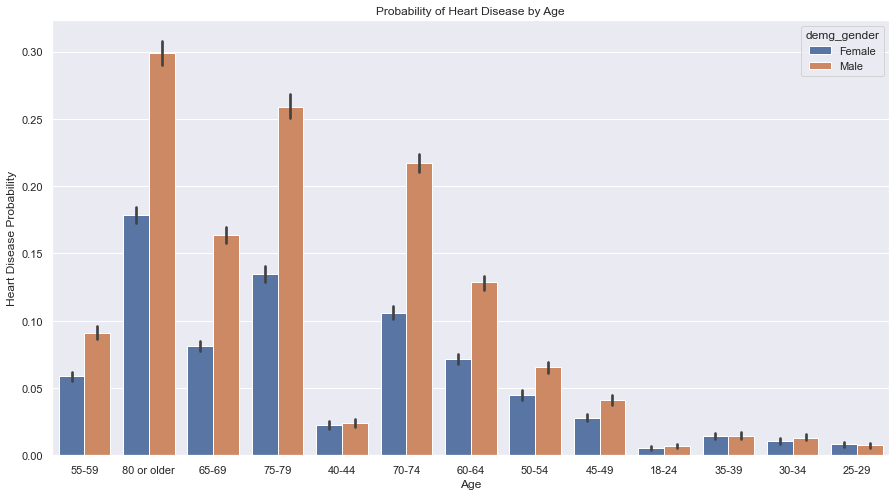

In [19]:
# plot heart disease probability by age and gender

sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x='demg_age', y='y_heart_disease', hue='demg_gender', data=df_map)
plt.ylabel('Heart Disease Probability')
plt.xlabel('Age')
plt.title('Probability of Heart Disease by Age')
plt.savefig("prob_hd_age.svg");


In [20]:
# map: 
    # disease_diabetes ['Yes' 'No' 'No, borderline diabetes' 'Yes (during pregnancy)'] #adjust in next cell
    # demo_gender ['Female' 'Male']
    # demo_race ['White' 'Black' 'Asian' 'American Indian/Alaskan Native' 'Other' 'Hispanic'] (alpha order)
    # health_general ['Very good' 'Fair' 'Good' 'Poor'=1 'Excellent'=5]

df_map = df_map.replace({'Yes (during pregnancy)': 2,           #Diabetes
                 'No, borderline diabetes': 3,  
                 'Female': 1,                                   #Sex 
                 'Male': 2,                             
                 'American Indian/Alaskan Native': 1,           #Race  
                 'Asian':2,                     
                 'Black':3,                      
                 'Hispanic':4,                   
                 'Other': 5,                     
                 'White': 6,                     
                 'Poor': 1,                                     #Health_General
                 'Fair': 2,                     
                 'Good': 3,                     
                 'Very good': 4,                
                 'Excellent': 5})               


In [21]:
# map age to lowest in bin: 
    # demo_age ['55-59' '80 or older' '65-69' '75-79' '40-44' '70-74' '60-64' '50-54' '45-49' 
                #'18-24' '35-39' '30-34' '25-29']

df_map = df_map.replace({'18-24':18,
             '25-29':25, 
             '30-34':30, 
             '35-39':35, 
             '40-44':40, 
             '45-49':45, 
             '50-54':50,
             '55-59':55,
             '60-64':60,
             '65-69':65,
             '70-74':70,
             '75-79':75,    
             '80 or older':80})


In [22]:
# list unique values by column to verify mapped properly

for col in df_map :
    print(col, df_map[col].unique())

behavior_activity [1 0]
behavior_alcohol [0 1]
behavior_sleep [ 5.  7.  8.  6. 12.  4.  9. 10. 15.  3.  2.  1. 16. 18. 14. 20. 11. 13.
 17. 24. 19. 21. 22. 23.]
behavior_tobacco [1 0]
demg_age [55 80 65 75 40 70 60 50 45 18 35 30 25]
demg_gender [1 2]
demg_race [6 3 2 1 5 4]
disease_asthma [1 0]
disease_diabetes [1 0 3 2]
disease_kidney [0 1]
disease_skin [1 0]
disease_stroke [0 1]
health_bmi [16.6  20.34 26.58 ... 62.42 51.46 46.56]
health_general [4 2 3 1 5]
health_mental [30.  0.  2.  5. 15.  8.  4.  3. 10. 14. 20.  1.  7. 24.  9. 28. 16. 12.
  6. 25. 17. 18. 21. 29. 22. 13. 23. 27. 26. 11. 19.]
health_mobility [0 1]
health_physical [ 3.  0. 20. 28.  6. 15.  5. 30.  7.  1.  2. 21.  4. 10. 14. 18.  8. 25.
 16. 29. 27. 17. 24. 12. 23. 26. 22. 19.  9. 13. 11.]
y_heart_disease [0 1]


In [23]:
# save and pickle df_map

heart_disease_df_map = df_map
heart_disease_df_map.to_pickle('heart_disease_df_map.pkl')
heart_disease_df_map.to_csv(r'/Users/sandraparedes/Documents/GitHub/metis_dsml/04_classification/g00-classification_project/heart_disease_df_map.csv', index=False)


[back to top](#top)

### 3b. Prepare for baselining

In [24]:
# separate target from select features using mapped variables
y_map = df_map['y_heart_disease'] 

X_map = df_map.loc[:, ['behavior_activity', 
                       'behavior_alcohol', 
                       'behavior_sleep',
                       'behavior_tobacco', 
                       'demg_age', 
                       'demg_gender', 
                       'demg_race',
                       'disease_asthma', 
                       'disease_diabetes', 
                       'disease_kidney', 
                       'disease_skin', 
                       'disease_stroke', 
                       'health_bmi', 
                       'health_general', 
                       'health_mental',
                       'health_mobility', 
                       'health_physical']]

In [25]:
# split map df into test/train/validate
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_map, 
                                                    y_map, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train_m, X_validate_m, y_train_m, y_validate_m = train_test_split(X_train_m, y_train_m, 
                                                            test_size = .25, random_state = 42)


In [26]:
# baseline rate of target using the mean of training data
print('Baseline probability of heart disease on y_train_map:',   (round(np.mean(y_train_m), 4)*100),'%')


Baseline probability of heart disease on y_train_map: 8.49 %


### 3c. Baseline: Logistic regression using mapped variables

In [27]:
# scale map X train/test
scaler_map = StandardScaler()
X_train_scaled_m = scaler_map.fit_transform(X_train_m)
X_test_scaled_m = scaler_map.transform(X_test_m)
X_validate_scaled_m = scaler_map.transform(X_validate_m)

#logistic regression on map X train scaled & y train
logreg_map = LogisticRegression()
logreg_map.fit(X_train_scaled_m, y_train_m)


LogisticRegression()

In [28]:
# score map_df on X_test_scaled and y_test
print('Logistic regression score of map_df on X_test_scaled and y_test:')
print("recall:", round(recall_score(logreg_map.predict(X_test_scaled_m), y_test_m), 4))


Logistic regression score of map_df on X_test_scaled and y_test:
recall: 0.5327


In [29]:
# predict on X_validate_scaled_m 
y_pred_m = logreg_map.predict(X_validate_scaled_m) 

# score y_validate, y_predict with all metrics
print('Logistic regression score of map_df on y_validate and y_pred:')
print("recall:", round(recall_score(y_validate_m, y_pred_m), 4))

Logistic regression score of map_df on y_validate and y_pred:
recall: 0.0995


[back to top](#top)

## 4 | Model Iteration #1: Dummy Variables + Logistic Regression<a id='4'></a>  

In [30]:
df_dmy = heart_disease_df.copy()

### 4a. Create dummy variables

In [31]:
# dummy variables for non-numerical columns (commented out)
df_dmy = pd.get_dummies(data=df_dmy, 
                        columns=['behavior_activity', 
                                 'behavior_alcohol', 
#                                  'behavior_sleep',
                                 'behavior_tobacco', 
                                 'demg_age', 
                                 'demg_gender', 
                                 'demg_race',
                                 'disease_asthma', 
                                 'disease_diabetes', 
                                 'disease_kidney', 
                                 'disease_skin',
                                 'disease_stroke', 
#                                  'health_bmi', 
                                 'health_general', 
#                                  'health_mental',
                                 'health_mobility', 
#                                  'health_physical', 
                                 'y_heart_disease'],
                        drop_first=True)

# numerical features for reference: 
    # behavior_sleep [ 5.  7.  8.  6. 12.  4.  9. 10. 15.  3.  2.  1. 16. 18. 14. 20. 11. 13.
    # health_bmi [16.6  20.34 26.58 ... 62.42 51.46 46.56]
    # health_mental [30.  0.  2.  5. 15.  8.  4.  3. 10. 14. 20.  1.  7. 24.  9. 28. 16. 12. 6. 25. 17. 18. 21. 29. 22. 13. 23. 27. 26. 11. 19.]
    # health_physical [ 3.  0. 20. 28.  6. 15.  5. 30.  7.  1.  2. 21.  4. 10. 14. 18.  8. 25. 16. 29. 27. 17. 24. 12. 23. 26. 22. 19.  9. 13. 11.] 


In [32]:
df_dmy.rename(columns = {'disease_diabetes_Yes (during pregnancy)': 'disease_diabetes_Yes_pregnancy',
                         'disease_diabetes_No, borderline diabetes': 'disease_diabetes_No_borderline'}, 
              inplace = True)


In [33]:
df_dmy.columns

Index(['behavior_sleep', 'health_bmi', 'health_mental', 'health_physical',
       'behavior_activity_Yes', 'behavior_alcohol_Yes', 'behavior_tobacco_Yes',
       'demg_age_25-29', 'demg_age_30-34', 'demg_age_35-39', 'demg_age_40-44',
       'demg_age_45-49', 'demg_age_50-54', 'demg_age_55-59', 'demg_age_60-64',
       'demg_age_65-69', 'demg_age_70-74', 'demg_age_75-79',
       'demg_age_80 or older', 'demg_gender_Male', 'demg_race_Asian',
       'demg_race_Black', 'demg_race_Hispanic', 'demg_race_Other',
       'demg_race_White', 'disease_asthma_Yes',
       'disease_diabetes_No_borderline', 'disease_diabetes_Yes',
       'disease_diabetes_Yes_pregnancy', 'disease_kidney_Yes',
       'disease_skin_Yes', 'disease_stroke_Yes', 'health_general_Fair',
       'health_general_Good', 'health_general_Poor',
       'health_general_Very good', 'health_mobility_Yes',
       'y_heart_disease_Yes'],
      dtype='object')

In [34]:
# save and pickle df_dmy

heart_disease_df_dmy = df_dmy
heart_disease_df_dmy.to_pickle('heart_disease_df_dmy.pkl')
heart_disease_df_dmy.to_csv(r'/Users/sandraparedes/Documents/GitHub/metis_dsml/04_classification/g00-classification_project/heart_disease_df_dmy.csv', index=False)


[back to top](#top)

### 4b. Prepare for modeling

In [35]:
# separate target from select features using dummy variables
y_dmy = df_dmy['y_heart_disease_Yes']

X_dmy = df_dmy.loc[:, ['behavior_sleep', 
                       'health_bmi', 
                       'health_mental', 
                       'health_physical',
                       'behavior_activity_Yes', 
                       'behavior_alcohol_Yes', 
                       'behavior_tobacco_Yes',
                       'demg_age_25-29', 
                       'demg_age_30-34', 
                       'demg_age_35-39', 
                       'demg_age_40-44',
                       'demg_age_45-49', 
                       'demg_age_50-54', 
                       'demg_age_55-59', 
                       'demg_age_60-64',
                       'demg_age_65-69', 
                       'demg_age_70-74', 
                       'demg_age_75-79',
                       'demg_age_80 or older', 
                       'demg_gender_Male', 
                       'demg_race_Asian',
                       'demg_race_Black', 
                       'demg_race_Hispanic', 
                       'demg_race_Other',
                       'demg_race_White', 
                       'disease_asthma_Yes',
                       'disease_diabetes_No_borderline', 
                       'disease_diabetes_Yes',
                       'disease_diabetes_Yes_pregnancy', 
                       'disease_kidney_Yes',
                       'disease_skin_Yes', 
                       'disease_stroke_Yes', 
                       'health_general_Fair',
                       'health_general_Good', 
                       'health_general_Poor',
                       'health_general_Very good', 
                       'health_mobility_Yes']]


In [36]:
# split test dummy df into test/train/validate
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_dmy, 
                                                    y_dmy, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train_d, X_validate_d, y_train_d, y_validate_d = train_test_split(X_train_d, y_train_d,
                                                                    test_size = .25, random_state = 4)

In [37]:
# baseline rate of target using the mean of training data
print('Baseline probability of heart disease on y_train_dummy:', (round(np.mean(y_train_d), 4)*100),'%')


Baseline probability of heart disease on y_train_dummy: 8.55 %


[back to top](#top)

### 4c. Iteration #1: Logistic regression using dummy variables<a id='4c'></a>  

In [38]:
# scale dummy X train/test
scaler_dummy = StandardScaler()
X_train_scaled_d = scaler_dummy.fit_transform(X_train_d)
X_test_scaled_d = scaler_dummy.transform(X_test_d)
X_validate_scaled_d = scaler_dummy.transform(X_validate_d)

# logistic regression on dummy X train scaled & y train
logreg_dmy = LogisticRegression()
logreg_dmy.fit(X_train_scaled_d, y_train_d)


LogisticRegression()

In [39]:
# score dummy_df on X_test_scaled and y_test
print('Logistic regression score of dummy_df on X_test_scaled and y_test:')
print("recall:", round(recall_score(logreg_dmy.predict(X_test_scaled_d), y_test_d), 4))


Logistic regression score of dummy_df on X_test_scaled and y_test:
recall: 0.5318


In [40]:
# predict on X_validate_scaled_d 
y_pred_d = logreg_dmy.predict(X_validate_scaled_d) 

# score y_validate, y_predict with all metrics
print('Logistic regression score of dummy_df on y_validate and y_pred:')
print("recall:", round(recall_score(y_validate_d, y_pred_d), 4))

Logistic regression score of dummy_df on y_validate and y_pred:
recall: 0.1053


[back to top](#top)

## 5. Preliminary Visualization<a id='5'></a> 


#### Figure 2. ROC Curve: Logistic Regression + Mapped Features<a id='5a'></a>

ROC AUC score mapped =  0.8411


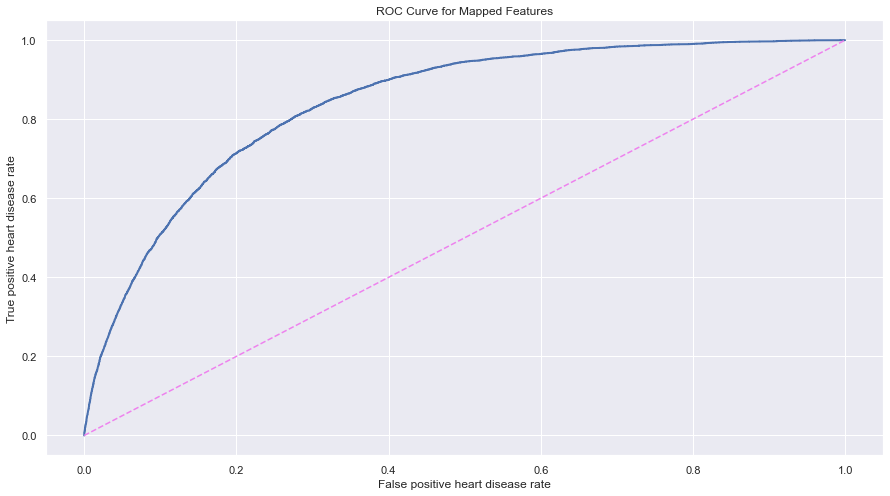

In [41]:
fpr, tpr, thresholds = roc_curve(y_validate_m, logreg_map.predict_proba(X_validate_scaled_m)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive heart disease rate')
plt.ylabel('True positive heart disease rate')
plt.title('ROC Curve for Mapped Features');
print("ROC AUC score mapped = ", round(roc_auc_score(y_validate_m, logreg_map.predict_proba(X_validate_scaled_m)[:,1]), 4))
plt.savefig("roc_curve_mapped.svg");



[back to top](#top)

#### Figure 3. ROC Curve: Logistic Regression + Dummy Features<a id='5b'></a>

ROC AUC score dummy =  0.8363


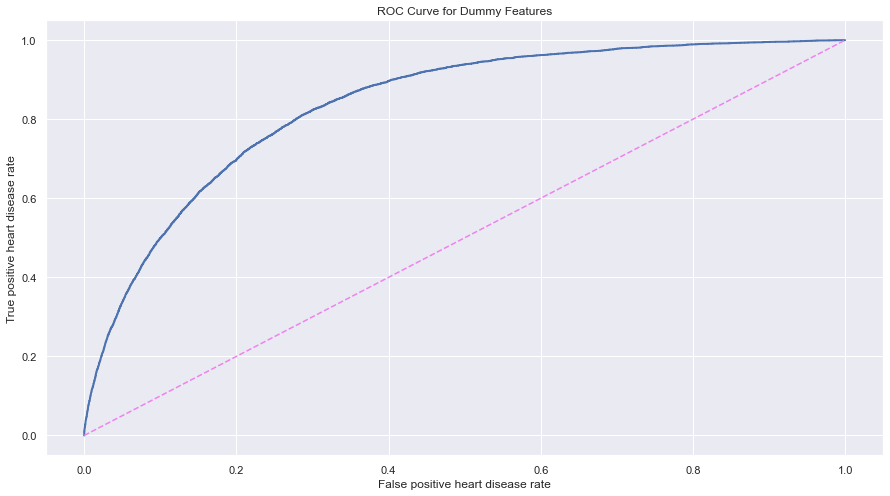

In [42]:
fpr, tpr, thresholds = roc_curve(y_validate_d, logreg_dmy.predict_proba(X_validate_scaled_d)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive heart disease rate')
plt.ylabel('True positive heart disease rate')
plt.title('ROC Curve for Dummy Features');
print("ROC AUC score dummy = ", round(roc_auc_score(y_validate_d, logreg_dmy.predict_proba(X_validate_scaled_d)[:,1]),4))
plt.savefig("roc_curve_dummy.svg");



[back to top](#top)